# Image Analysis with Amazon Bedrock Data Automation: Seeing Beyond Text

This notebook expands your journey with Amazon Bedrock Data Automation (BDA) by moving beyond text-based content to explore the rich world of visual data. While document processing lays the foundation for structured extraction, image analysis represents a fundamental shift in how we interact with information that cannot be captured in text alone.

As you work through this notebook, you'll build capabilities to:
- Extract textual information embedded within images
- Identify and analyze visual objects and logos
- Generate comprehensive descriptions of visual content
- Classify images according to standard taxonomies
- Extract custom attributes from specialized image types

This notebook demonstrates how to use Amazon Bedrock Data Automation (BDA) to analyze images and extract valuable insights. BDA can identify text, logos, objects, and generate summaries from images, making it powerful for various image analysis tasks.

In this enhanced notebook, we'll focus on the core BDA workflow for image analysis:

1. Preparing a sample image
2. Creating a BDA project with standard and custom output configurations
3. Processing the image with BDA
4. Analyzing the results

The setup cell below contains helper functions and initialization code. **It's collapsed by default** - you can expand it to see the details, but you don't need to understand all of it to follow the main BDA workflow.

In [1]:
# This cell contains setup code and helper functions.
# You can expand it to see the details, but you don't need to understand all of it.

import boto3
import json
import uuid
import time
import os
import sagemaker
from datetime import datetime
from IPython.display import Image, clear_output, display, Markdown, HTML
from PIL import Image as PILImage, ImageDraw
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import all utilities from the consolidated utils
from utils.utils import BDAImageUtils, show_business_context, download_image, ensure_bda_results_dir, visualize_detections

# Initialize our utility class
bda_utils = BDAImageUtils()

# Display comprehensive business context for image analysis
show_business_context("image_analysis_complete")

print(f"Setup complete. BDA utilities initialized for region: {bda_utils.current_region}")
print(f"Using S3 bucket: {bda_utils.bucket_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Bucket bda-workshop-us-west-2-033741858282 already exists



Amazon Bedrock Data Automation (BDA) enables you to extract structured insights from images by leveraging
generative AI to analyze visual content and transform it into actionable information.

### Business Value

- **Automated Visual Understanding**: Extract text, detect objects, identify logos, and generate descriptions from images at scale
- **Visual Content Integration**: Transform unstructured visual data into structured formats that integrate with business systems
- **Multimodal Intelligence**: Combine visual analysis with other data modalities to create comprehensive understanding
- **Development Acceleration**: Eliminate the need to build and maintain complex computer vision pipelines

### Key Detection Capabilities

- **Text Detection**: Extract printed and handwritten text from images with precise bounding boxes
- **Logo Detection**: Identify corporate logos and brand marks with location information
- **Object Detection**: Recognize common objects, scenery elements, and visual concepts
- **Category Classification**: Automatically categorize images into industry-standard IAB categories

### Industry Applications

- **Retail**: Product recognition for inventory management and customer experiences
- **Marketing**: Measure brand presence through logo detection in digital and print media
- **Content Moderation**: Identify potentially unsafe or inappropriate visual content
- **Document Processing**: Extract text from forms, receipts, and image-based documents


Setup complete. BDA utilities initialized for region: us-west-2
Using S3 bucket: bda-workshop-us-west-2-033741858282


## Industry Applications

As you work through this notebook, consider how image analysis could transform workflows in your specific domain:

**Retail**: How would automatic product detection, logo identification, and attribute extraction from product images change your catalog management and customer experiences?

**Marketing & Advertising**: What if your campaigns could automatically measure brand presence, analyze ad composition, and extract text from visual promotional materials?

**Manufacturing**: How could visual quality inspection, defect detection, and component identification from product images transform your production processes?

**Healthcare**: What new possibilities would emerge from analyzing medical images, identifying visual indicators, and extracting measurements from diagnostic visuals?

**Your Industry**: What types of images are critical to your organization's workflows? What insights within these images would provide the most business value if automatically extracted?

## 1. Prepare Sample Image

First, we'll download a sample advertisement image and upload it to S3 for processing with BDA. This image contains text, logos, and other elements that BDA can analyze.

The image will be stored in an S3 bucket that BDA can access. This is a required step as BDA needs to read the image from S3.

Downloaded https://d1xvhy22zmw77y.cloudfront.net/tmp/travel.png to travel.png


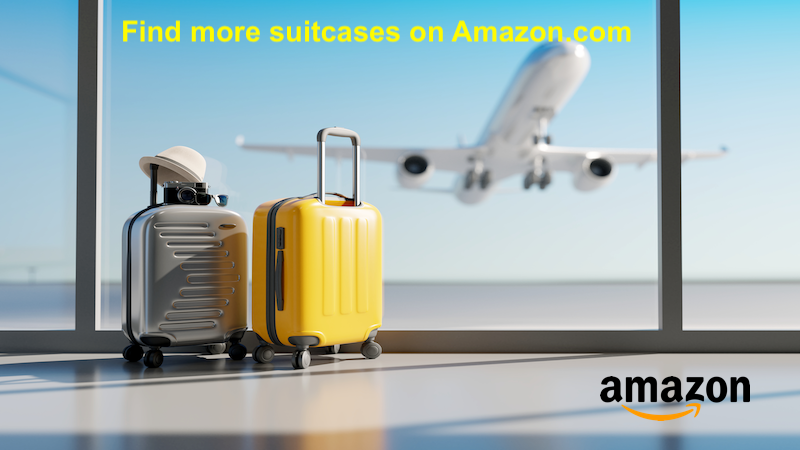

Uploaded image to S3: s3://bda-workshop-us-west-2-033741858282/bda-workshop/image/travel.png


In [2]:
# Download sample image
sample_image = 'travel.png'
source_url = f'https://d1xvhy22zmw77y.cloudfront.net/tmp/{sample_image}'

# Download the image locally using enhanced download function
local_path = download_image(source_url, sample_image) or bda_utils.download_image(source_url, sample_image)

# Display the image
display(Image(sample_image, width=800))

# Upload to S3
s3_key = f'{bda_utils.data_prefix}/{sample_image}'
s3_uri = bda_utils.upload_to_s3(sample_image, s3_key)
print(f"Uploaded image to S3: {s3_uri}")

## 2. Define BDA Configuration

Before creating a BDA project, we need to define both standard and custom output configurations. These configurations determine what information BDA will extract from the image.

### BDA Configuration Details

### Standard Output Configuration

The standard output configuration includes:

- **Text Detection**: Extract text from the image with bounding boxes
- **Logo Detection**: Identify brand logos with bounding boxes
- **Image Summary**: Generate a descriptive summary of the image
- **IAB Categories**: Classify the image into Internet Advertising Bureau categories

### Custom Output Configuration (Blueprint)

We'll also create a custom blueprint to extract specific information about the advertisement:

- **Product Type**: What product or service is being advertised
- **Product Count**: Number of products visible in the image
- **Scene Location**: Setting or location of the scene
- **Image Background**: Type of background in the image

In [3]:
# Display business context for custom blueprints
show_business_context("custom_blueprints")

# Define the custom blueprint for image analysis
# This blueprint defines the schema for extracting specific information from advertisement images
blueprint = {
    # Top-level class and description define the overall purpose of the blueprint
    "class": "Ad scene analysis",  # Name of the blueprint class
    "description": "This blueprint is designed to extract key information from an image depicting an Ad scene.",
    
    # Definitions section contains reusable property groups that can be referenced elsewhere
    "definitions": {
        "ProductDetails": {  # Define a reusable group of properties for product information
            "properties": {
                "product_type": {  # Extract the type of product being advertised
                  "type": "string",  # Expect a string response
                  "inferenceType": "inferred",  # This will be inferred by AI, not extracted directly
                  "instruction": "What is the primary product or service being advertised, e.g., Clothing, Electronics, Food & Beverage, etc.?"
                },
                "product_count": {  # Count the number of products visible
                    "type": "number",  # Expect a numeric response
                    "inferenceType": "inferred",
                    "instruction": "Count the number of product visible in the image."
                },
                "scene_location": {  # Describe the setting of the advertisement
                  "type": "string",
                  "inferenceType": "inferred",
                  "instruction": "Describe the setting or location of the scene, such as the type of field or surrounding buildings."
                }
            }
        }
    },
    
    # Root-level properties to extract from the image
    "properties": {
        "product_details": {  # Use the ProductDetails definition from above
            "instruction": "Detailed information about the advertised product, including its category, name, and placement within the image.",
            "$ref": "#/definitions/ProductDetails"  # Reference to the definition above
        },
        "image_background": {  # Additional property at the root level
            "type": "string",
            "inferenceType": "inferred",
            "instruction": "What is the background of the ad image? For example, \u0027Solid color\u0027, \u0027Natural landscape\u0027, \u0027Indoor\u0027, \u0027Urban\u0027, \u0027Abstract\u0027"
        }
    }
}

# Generate a unique blueprint name to avoid naming conflicts
unique_id = str(uuid.uuid4())[0:6]
blueprint_name = f"bda-image-custom-blueprint-{unique_id}"

print(f"Creating blueprint with name: {blueprint_name}")

# Create the blueprint in BDA
try:
    bp_response = bda_utils.bda_client.create_blueprint(
        blueprintName=blueprint_name,
        type='IMAGE',  # Specify this is for image analysis
        blueprintStage='DEVELOPMENT',  # Use development stage for workshop
        schema=json.dumps(blueprint),  # Convert blueprint dict to JSON string
    )
    
    blueprint_arn = bp_response.get("blueprint", {}).get("blueprintArn")
    print(f"Blueprint created successfully with ARN: {blueprint_arn}")
except Exception as e:
    print(f"Error creating blueprint: {e}")
    blueprint_arn = None


### What are Blueprints?
Blueprints define structured extraction patterns that allow you to customize how BDA analyzes your specific visual content. They bridge the gap between general-purpose AI capabilities and your unique business requirements.

### Key Advantages of Blueprints

1. **Domain-Specific Extraction**: Target exactly the information that matters to your business case

2. **Consistent Structure**: Ensure all extracted data follows a predictable JSON schema for easier integration

3. **Reduced Post-Processing**: Get data in the format you need without additional transformation steps

4. **Business Logic Integration**: Embed business rules directly into your extraction patterns

5. **Versioned Evolution**: Refine your extraction patterns over time while maintaining compatibility

### Blueprint Components

- **Properties**: Define the fields to extract
- **Inference Types**: Control how fields are populated (extracted vs. inferred)
- **Instructions**: Guide the AI in extracting specific information
- **Definitions**: Create reusable structures for complex extraction patterns

### When to Use Blueprints

Blueprints are particularly valuable when:
- Standard outputs don't capture your specific information needs
- You need consistent structure for downstream processing
- Your domain has specialized terminology or concepts
- You're integrating visual analysis with existing business systems

### Blueprint Capabilities for Images

- **Custom Attributes**: Define specific attributes you want to extract from images
- **Structured Output**: Get results in a consistent JSON schema that matches your business needs
- **Domain-Specific Analysis**: Create specialized extraction for retail, medical, advertising, or other domains
- **Guided LLM Analysis**: Provide instructions that guide the AI in analyzing your specific image types

### Business Applications

- **Product Catalogs**: Extract specific product attributes from product images
- **Marketing Analysis**: Define custom metrics for analyzing advertisement images
- **Quality Control**: Create specialized inspection attributes for manufacturing
- **Scene Understanding**: Define custom scene attributes for security or surveillance applications

### AWS Documentation Resources

- For blueprint schema documentation, see: https://docs.aws.amazon.com/bedrock/latest/userguide/bda-blueprint-info.html


Creating blueprint with name: bda-image-custom-blueprint-521764
Blueprint created successfully with ARN: arn:aws:bedrock:us-west-2:033741858282:blueprint/35f712cc22e5


## 3. Create BDA Project

Now we'll create a BDA project with our standard and custom output configurations. The project stores the configuration settings that will be used to process images.

### Project Architecture for Image Analysis

### Key Parameters for `create_data_automation_project` API:

- **projectName**: A unique name for the project
- **projectDescription**: A description of the project's purpose
- **projectStage**: The stage of the project (DEVELOPMENT or LIVE)
- **standardOutputConfiguration**: The standard output settings
- **customOutputConfiguration**: The custom blueprint configuration

The project ARN returned by this API will be used when invoking BDA to process images.

In [4]:
# Show business context for project architecture
show_business_context("project_architecture")

# Create a BDA project with both standard and custom output configurations
print("Creating BDA project for image analysis...")
response = bda_utils.bda_client.create_data_automation_project(
    projectName=f'bda-workshop-image-project-{str(uuid.uuid4())[0:4]}',
    projectDescription='BDA workshop image sample project',
    projectStage='DEVELOPMENT',
    standardOutputConfiguration={
        'image': {
            'extraction': {
                'category': {
                    'state': 'ENABLED',
                    'types': [
                        'TEXT_DETECTION',  # Extract text from the image
                        'LOGOS'            # Identify brand logos
                    ]
                },
                'boundingBox': {
                    'state': 'ENABLED'     # Include bounding boxes for detected elements
                }
            },
            'generativeField': {
                'state': 'ENABLED',
                'types': [
                    'IMAGE_SUMMARY',       # Generate a summary of the image
                    'IAB'                  # Classify into IAB categories
                ]
            }
        },
    },
    customOutputConfiguration={
        'blueprints': [
            {
                'blueprintArn': blueprint_arn,
                'blueprintStage': 'DEVELOPMENT'
            },
        ]
    },
)

# Get the project ARN
image_project_arn = response.get("projectArn")
print(f"BDA project created with ARN: {image_project_arn}")


Projects are a fundamental architectural component in Amazon Bedrock Data Automation. For image analysis, they provide several key benefits:

1. **Consistent Configuration**: Projects store processing configurations that ensure consistent analysis across multiple images or image batches.

2. **Feature Selection**: Projects let you specify which visual features to extract (text, logos, objects) and which generative outputs to create (summaries, classifications).

3. **Custom Extraction Logic**: Through blueprints, projects can define specialized extraction patterns tailored to your specific visual analysis needs.

4. **Environment Separation**: Different projects can be created for development, testing, and production environments, allowing you to evolve your image analysis capabilities safely.

5. **Access Management**: Projects provide a way to control who can invoke specific types of image analysis, supporting governance requirements.

In production environments, you typically create different projects for different image types or analysis requirements, each with optimized configurations.


Creating BDA project for image analysis...
BDA project created with ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-project/4ec7dad758a2


## 4. Process Image with BDA

Now we'll use the `invoke_data_automation_async` API to process our image with BDA. This API starts an asynchronous job to analyze the image and extract insights based on our project configuration.

In [5]:
# Show business context for processing pipeline
show_business_context("processing_pipeline")

# Invoke BDA to process the image
print(f"Processing image: {s3_uri}")
print(f"Results will be stored at: s3://{bda_utils.bucket_name}/{bda_utils.output_prefix}")

# Call the invoke_data_automation_async API
response = bda_utils.bda_runtime_client.invoke_data_automation_async(
    inputConfiguration={
        's3Uri': s3_uri  # The S3 location of our image
    },
    outputConfiguration={
        's3Uri': f's3://{bda_utils.bucket_name}/{bda_utils.output_prefix}'  # Where to store results
    },
    dataAutomationConfiguration={
        'dataAutomationProjectArn': image_project_arn,  # The project we created
        'stage': 'DEVELOPMENT'                          # Must match the project stage
    },
    dataAutomationProfileArn=f'arn:aws:bedrock:{bda_utils.current_region}:{bda_utils.account_id}:data-automation-profile/us.data-automation-v1'
)

# Get the invocation ARN
invocation_arn = response['invocationArn']
print(f"Invocation ARN: {invocation_arn}")

# Wait for processing to complete
status_response = bda_utils.wait_for_completion(
    get_status_function=bda_utils.bda_runtime_client.get_data_automation_status,
    status_kwargs={'invocationArn': invocation_arn},
    completion_states=['Success'],
    error_states=['ClientError', 'ServiceError'],
    status_path_in_response='status',
    max_iterations=15,
    delay=10
)

# Check if processing was successful
if status_response['status'] == 'Success':
    output_config_uri = status_response.get("outputConfiguration", {}).get("s3Uri")
    print(f"\nImage processing completed successfully!")
    print(f"Output configuration: {output_config_uri}")
else:
    print(f"\nImage processing failed with status: {status}")
    if 'error_message' in status_response:
        print(f"Error message: {status_response['error_message']}")


When you invoke Amazon Bedrock Data Automation for image analysis, a sophisticated processing pipeline is executed:

### Processing Steps

1. **Image Ingestion**: The system loads and preprocesses the image from S3
2. **Initial Analysis**: Computer vision models identify key visual elements (text, logos, objects)
3. **Spatial Mapping**: Bounding boxes and polygons are calculated for detected elements
4. **Content Moderation**: Optional scanning for inappropriate content across 7 categories
5. **Semantic Analysis**: Generative AI creates descriptions and classifications of image content
6. **IAB Categorization**: Application of standardized advertising taxonomy categories
7. **Result Formation**: All extracted data is assembled into the requested output format

### Performance Considerations

- Processing time depends on image complexity, size, and requested detection types
- High-resolution images with many elements take longer to process
- Typical processing times range from seconds to a minute for complex images
- Response includes important image metadata (dimensions, color depth, encoding)


Processing image: s3://bda-workshop-us-west-2-033741858282/bda-workshop/image/travel.png
Results will be stored at: s3://bda-workshop-us-west-2-033741858282/bda-workshop/image/output
Invocation ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-invocation/5d3c053f-34cc-4993-a99b-65f71290b8f7
Current status: InProgress
Waiting 10 seconds...
Current status: Success
Process completed with status: Success

Image processing completed successfully!
Output configuration: s3://bda-workshop-us-west-2-033741858282/bda-workshop/image/output/5d3c053f-34cc-4993-a99b-65f71290b8f7/job_metadata.json


## 5. Analyze BDA Results

Finally, we'll retrieve and analyze the results from BDA. We'll break this analysis into several focused sections:

1. Job metadata and overview 
2. Image summary and classification
3. Visual elements detection (text, logos)
4. Custom analysis and practical applications

### 5.1 Job Metadata and Overview

In [6]:
# Show business context for business applications
show_business_context("business_applications")

# Load job metadata
config_data = bda_utils.read_json_from_s3(output_config_uri)

# Get standard output path
standard_output_path = config_data["output_metadata"][0]["segment_metadata"][0]["standard_output_path"]
standard_output = bda_utils.read_json_from_s3(standard_output_path)

# Get custom output path
custom_output_path = config_data["output_metadata"][0]["segment_metadata"][0]["custom_output_path"]
custom_output = bda_utils.read_json_from_s3(custom_output_path)

# Display job metadata
print("=== Job Information ===")
print(f"Job ID: {config_data.get('job_id', 'N/A')}")
print(f"Input type: {config_data.get('input_type', 'N/A')}")
print(f"Asset count: {len(config_data.get('output_metadata', []))}")

# Display image metadata
print("\n=== Image Metadata ===")
metadata = standard_output["metadata"]
print(f"Width: {metadata.get('image_width_pixels', 'N/A')} pixels")
print(f"Height: {metadata.get('image_height_pixels', 'N/A')} pixels")
print(f"Format: {metadata.get('image_format', 'N/A')}")


The structured data extracted from images by BDA enables various business applications that transform how organizations work with visual content.

### Practical Applications

- **Product Analysis**: Extract product attributes from catalog images
- **Brand Monitoring**: Track logo appearances across digital and print media
- **Content Organization**: Automatically tag and categorize visual content
- **Text Digitization**: Extract text from images for analysis and search
- **Visual Search**: Enable search functionality based on image content
- **Content Moderation**: Filter inappropriate content across 7 categories (Explicit, Non-Explicit Nudity, Swimwear/Underwear, Violence, Drugs & Tobacco, Alcohol, and Hate Symbols)
- **Ad Targeting**: Match content to appropriate advertising using IAB taxonomy

### Integration Patterns

- **API Integration**: Connect with CRM, DAM, and other business systems
- **Data Pipelines**: Feed extracted information into analytics systems
- **Content Automation**: Trigger workflows based on visual content analysis
- **Multimodal Applications**: Combine with other data sources for richer insights
- **Knowledge Bases**: Feed extracted image insights into Bedrock Knowledge Bases for multimodal RAG


=== Job Information ===
Job ID: 5d3c053f-34cc-4993-a99b-65f71290b8f7
Input type: N/A
Asset count: 1

=== Image Metadata ===
Width: 800 pixels
Height: 450 pixels
Format: N/A


### 5.2 Image Summary and Classification

In [7]:
# Show business context for image classification
show_business_context("image_classification")

# Display image summary
print("=== Image Summary ===")
print(standard_output["image"]["summary"])

# Display IAB categories
print("\n=== IAB Categories ===")
for iab in standard_output["image"]["iab_categories"]:
    # Check if confidence key exists before trying to access it
    if 'confidence' in iab:
        print(f"- {iab['category']} (Confidence: {iab['confidence']:.2f})")
    else:
        print(f"- {iab['category']}")


BDA's classification capabilities provide actionable insights from visual content that can transform business operations.

### Classification Features

- **IAB Taxonomy**: Classification using the Internet Advertising Bureau's industry-standard categories (supports 24 top-level and 85 second-level categories)
- **Custom Classifications**: Add your own categories through custom blueprints
- **Confidence Scores**: Understand the reliability of classifications for better decision-making
- **Multi-Label Classification**: Images can belong to multiple relevant categories with parent-child relationships

### Business Impact

- **Content Recommendation**: Power recommendation engines with automatic content categorization
- **Advertising Targeting**: Match ads to appropriate visual content based on classifications
- **Digital Asset Management**: Organize and retrieve visual assets using automatic categorization
- **Content Compliance**: Ensure visual content meets industry guidelines and regulations


=== Image Summary ===
This image shows two suitcases placed in front of a large window with a view of an airplane taking off. The suitcases are positioned on the floor, with one being yellow and the other gray. A hat is placed on top of the gray suitcase. The scene is set in what appears to be an airport terminal. There is a prominent advertisement text overlaying the image that reads "Find more suitcases on Amazon.com". Additionally, the Amazon logo is visible at the bottom right corner of the image.

=== IAB Categories ===
- Travel (Confidence: 1.00)
- Travel Accessories (Confidence: 1.00)
- Business and Finance (Confidence: 0.96)
- Business (Confidence: 0.96)
- Style and Fashion (Confidence: 0.81)
- Women's Fashion (Confidence: 0.81)


### 5.3 Visual Elements Detection (Text & Logos)


Text contained within images represents valuable information that traditional systems can't easily access. 
Amazon Bedrock Data Automation helps bridge this gap by extracting text from images.

### Text Extraction Features

- **Text Detection**: Identify and extract text from images with precise bounding boxes
- **Spatial Recognition**: Understand where text appears within the image with polygon mapping
- **Confidence Scoring**: Each detected text element includes a confidence score for validation
- **Hierarchical Structure**: Text is organized by lines and words with parent-child relationships
- **Visual Context Understanding**: Recognize text in relation to other visual elements

### Business Applications

- **Receipt Processing**: Extract purchase information from photographed receipts
- **Sign and Menu Reading**: Capture text from signs, menus, and displays
- **Form Processing**: Extract information from photographed or scanned forms
- **ID Document Reading**: Extract key information from identity documents

For multilingual document processing, the AWS ecosystem offers complementary solutions like Amazon Translate, which can be used together with BDA for comprehensive multilingual workflows.


=== Detected Text ===
1. Find more suitcases on Amazon.com
2. amazon

=== Detected Logos ===
1. amazon echo


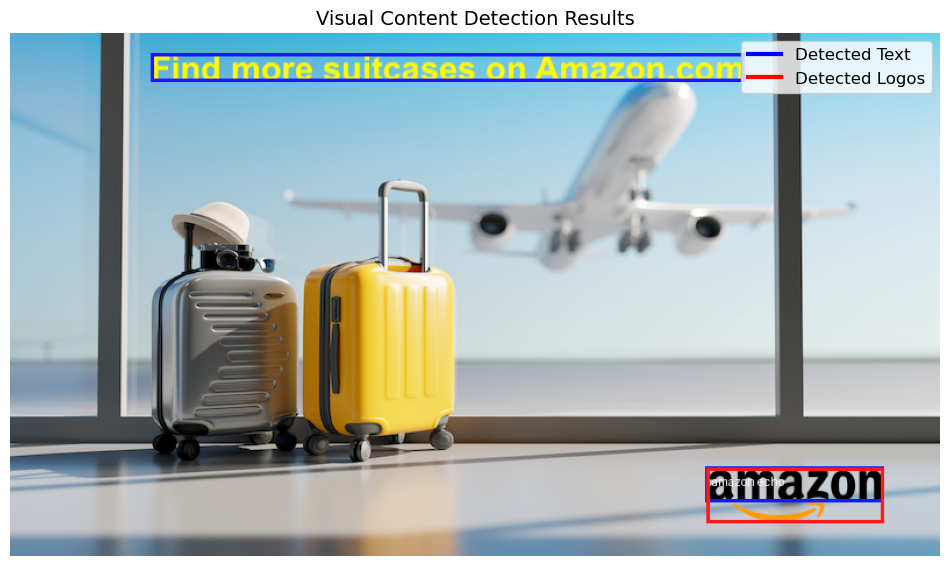

In [8]:
# Show business context for text extraction
show_business_context("text_in_image")

# Display detected text
print("=== Detected Text ===")
if "text_lines" in standard_output["image"]:
    for i, txt in enumerate(standard_output["image"]["text_lines"]):
        print(f"{i+1}. {txt['text']}")
else:
    print("No text detected")

# Display detected logos
print("\n=== Detected Logos ===")
if "logos" in standard_output["image"]:
    for i, logo in enumerate(standard_output["image"]["logos"]):
        print(f"{i+1}. {logo.get('name', 'Unknown logo')}")
else:
    print("No logos detected")
    
# Use our enhanced visualization function to show detections
visualization = visualize_detections(sample_image, standard_output)
visualization.show()

### 5.4 Custom Analysis and Practical Applications

In [9]:
# Create bda-results directory if it doesn't exist
ensure_bda_results_dir()

# Combine standard and custom outputs into a single result
combined_result = {
    "standard_output": standard_output,
    "custom_output": custom_output
}

# Save the combined result to the bda-results directory
with open('../bda-results/image_result.json', 'w') as f:
    json.dump(combined_result, f)
    
print(f"Saved image results to: ../bda-results/image_result.json")

# Display custom analysis results
print("\n=== Custom Analysis ===")
product_details = custom_output["inference_result"]["product_details"]
print(f"Product Type: {product_details['product_type']}")
print(f"Product Count: {product_details['product_count']}")
print(f"Scene Location: {product_details['scene_location']}")
print(f"Image Background: {custom_output['inference_result']['image_background']}")

Ensured BDA results directory exists.
Saved image results to: ../bda-results/image_result.json

=== Custom Analysis ===
Product Type: Suitcases
Product Count: 2.0
Scene Location: Airport terminal
Image Background: Indoor


## Summary

In this notebook, we demonstrated how to use Amazon Bedrock Data Automation (BDA) to analyze images and extract valuable insights. We covered the key steps in the BDA workflow and explored the powerful capabilities BDA offers for visual content analysis.

Through this hands-on exercise, we've seen how BDA can transform unstructured visual content into structured, actionable data that can power intelligent applications across various domains.

The journey from document processing to image analysis represents a significant expansion of our multimodal capabilities, laying the groundwork for even more advanced modalities in the upcoming modules.